## Prueba modelo ConvNeXt con XAI

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import json
from pathlib import Path

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset

In [18]:
os.makedirs('/root/.kaggle', exist_ok=True)

with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"nahomycastro","key":"e239a26cabfe03bd08a607337453ce27"}')

!chmod 600 /root/.kaggle/kaggle.json

print("Credenciales de Kaggle configuradas")

Credenciales de Kaggle configuradas


In [ ]:
!kaggle datasets download -d kanishk3813/pathogen-dataset
!unzip -q pathogen-dataset.zip -d pathogen_data

print("Dataset descargado y descomprimido")

Dataset URL: https://www.kaggle.com/datasets/kanishk3813/pathogen-dataset
License(s): apache-2.0
pathogen-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace pathogen_data/pathogen/Bacteria/Bacteria_original_enhanced_enhanced_image_10.jpg_102dc2b2-6122-411c-9dc1-afab0266507a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset descargado y descomprimido


### Rutas y Parámetros

In [22]:
MODEL_PATH = '/content/drive/MyDrive/convnext_final_best.keras'
DATA_DIR = 'pathogen_data/pathogen'
OUTPUT_DIR = 'test_results_xai'

In [23]:
IMG_SIZE = 256
CLASSES = ['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']
NUM_CLASSES = len(CLASSES)

In [24]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Carga de modelo

In [25]:
print(f"\nCargando modelo desde: {MODEL_PATH}")
try:
    model = keras.models.load_model(MODEL_PATH)
    print("Modelo cargado exitosamente!")
    print(f"   Arquitectura: {model.name}")
    print(f"   Total de parámetros: {model.count_params():,}")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    exit(1)


Cargando modelo desde: /content/drive/MyDrive/convnext_final_best.keras
Modelo cargado exitosamente!
   Arquitectura: ConvNeXt_Large_PathogenDetector
   Total de parámetros: 197,021,893


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 144 variables whereas the saved optimizer has 148 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Funciones para Grad-CAM+

In [26]:
def get_gradcam_heatmap(model, img_array, pred_index=None):
    """
    Genera un mapa de calor Grad-CAM++ para una imagen
    """
    if pred_index is None:
        preds = model.predict(img_array, verbose=0)
        pred_index = np.argmax(preds[0])

    last_conv_layer_name = None
    for layer in model.layers:
        if hasattr(layer, 'layers'):
            for sublayer in reversed(layer.layers):
                if 'conv' in sublayer.name.lower() or isinstance(sublayer, tf.keras.layers.Conv2D):
                    last_conv_layer_name = sublayer.name
                    break
            if last_conv_layer_name:
                break

    if last_conv_layer_name is None:
        print("No se encontró capa convolucional, usando capa alternativa")
        # Usar una capa anterior como fallback
        grad_model = tf.keras.models.Model(
            inputs=[model.inputs],
            outputs=[model.layers[-5].output, model.output]
        )
    else:
        base_model_layer = None
        for layer in model.layers:
            if hasattr(layer, 'layers') and len(layer.layers) > 0:
                base_model_layer = layer
                break

        if base_model_layer:
            last_conv_layer = base_model_layer.get_layer(last_conv_layer_name)
            grad_model = tf.keras.models.Model(
                inputs=[model.inputs],
                outputs=[last_conv_layer.output, model.output]
            )
        else:
            grad_model = tf.keras.models.Model(
                inputs=[model.inputs],
                outputs=[model.layers[-5].output, model.output]
            )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(len(pooled_grads)):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap /= heatmap.max()

    return heatmap

In [27]:
def visualize_prediction_with_xai(model, img_path, true_label=None):
    """
    Visualiza una predicción con XAI (Grad-CAM++)
    """
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array_original = img_array.copy()

    img_array = tf.keras.applications.convnext.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array, verbose=0)
    pred_class = np.argmax(predictions[0])
    confidence = predictions[0][pred_class]

    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    top_3_probs = predictions[0][top_3_idx]

    try:
        heatmap = get_gradcam_heatmap(model, img_array, pred_class)
    except Exception as e:
        print(f"Error en Grad-CAM: {str(e)[:100]}")
        heatmap = np.random.rand(8, 8)

    img_display = img_array_original / 255.0

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))

    heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]

    superimposed = heatmap_colored * 0.4 + img_display * 0.6

    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.8])

    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(img_display)
    ax1.set_title('Imagen Original', fontsize=14, fontweight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[1])
    im = ax2.imshow(heatmap, cmap='jet')
    ax2.set_title('Grad-CAM++ Heatmap', fontsize=14, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = fig.add_subplot(gs[2])
    ax3.imshow(superimposed)
    ax3.set_title('Regiones de Interés', fontsize=14, fontweight='bold')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[3])
    ax4.axis('off')

    if true_label is not None:
        correct = (CLASSES[pred_class] == true_label)
        color = 'green' if correct else 'red'
        title_text = f"{'¡Correcto!' if correct else '¡Incorrecto!'} Predicción: {CLASSES[pred_class]}\n"
        title_text += f"Real: {true_label}\n"
        title_text += f"Confianza: {confidence:.1%}"
    else:
        color = 'blue'
        title_text = f"Predicción: {CLASSES[pred_class]}\n"
        title_text += f"Confianza: {confidence:.1%}"

    ax4.text(0.5, 0.9, title_text,
             transform=ax4.transAxes,
             fontsize=12, fontweight='bold',
             ha='center', va='top',
             bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

    y_pos = 0.65
    ax4.text(0.5, y_pos, "Top 3 Predicciones:",
             transform=ax4.transAxes,
             fontsize=11, fontweight='bold',
             ha='center')

    y_pos -= 0.1
    for idx, prob in zip(top_3_idx, top_3_probs):
        ax4.text(0.5, y_pos, f"{CLASSES[idx]}: {prob:.1%}",
                 transform=ax4.transAxes,
                 fontsize=10,
                 ha='center')
        y_pos -= 0.08

    filename = os.path.basename(img_path)
    fig.suptitle(f'Análisis XAI - {filename}',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()

    return fig, pred_class, confidence, predictions[0]

### Test de una única imagen

In [29]:
def test_single_image(image_path, true_label=None):
    """
    Prueba el modelo con una imagen específica
    """
    print(f"\nProbando imagen: {image_path}")

    if not os.path.exists(image_path):
        print(f"La imagen no existe: {image_path}")
        return

    try:
        fig, pred_class, confidence, all_probs = visualize_prediction_with_xai(
            model, image_path, true_label=true_label
        )

        output_filename = f"single_test_{os.path.basename(image_path).split('.')[0]}_xai.png"
        output_path = os.path.join(OUTPUT_DIR, output_filename)
        fig.savefig(output_path, dpi=200, bbox_inches='tight')

        print(f"\nRESULTADOS:")
        print(f"Predicción: {CLASSES[pred_class]}")
        print(f"Confianza: {confidence:.1%}")
        if true_label:
            print(f"Etiqueta real: {true_label}")
            print(f"Correcto: {'Sí' if CLASSES[pred_class] == true_label else 'No'}")

        print(f"\nProbabilidades de todas las clases:")
        for i, prob in enumerate(all_probs):
            print(f"      {CLASSES[i]}: {prob:.1%}")

        print(f"\nVisualización guardada en: {output_path}")
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

### Función principal de test


Prueba de imagen específica...

Probando imagen: /content/pathogen_data/pathogen/Pests/Pests_original_enhanced_image_1003.jpg_4d9d77a6-b2f4-446f-b18e-73e5de3a2dcf.jpg


Error en Grad-CAM: "Exception encountered when calling Functional.call().\n\n\x1b132875113501984\x1b\n\nArguments

RESULTADOS:
Predicción: Pests
Confianza: 99.9%
Etiqueta real: Pests
Correcto: Sí

Probabilidades de todas las clases:
      Bacteria: 0.0%
      Fungi: 0.0%
      Healthy: 0.0%
      Pests: 99.9%
      Virus: 0.1%

Visualización guardada en: test_results_xai/single_test_Pests_original_enhanced_image_1003_xai.png


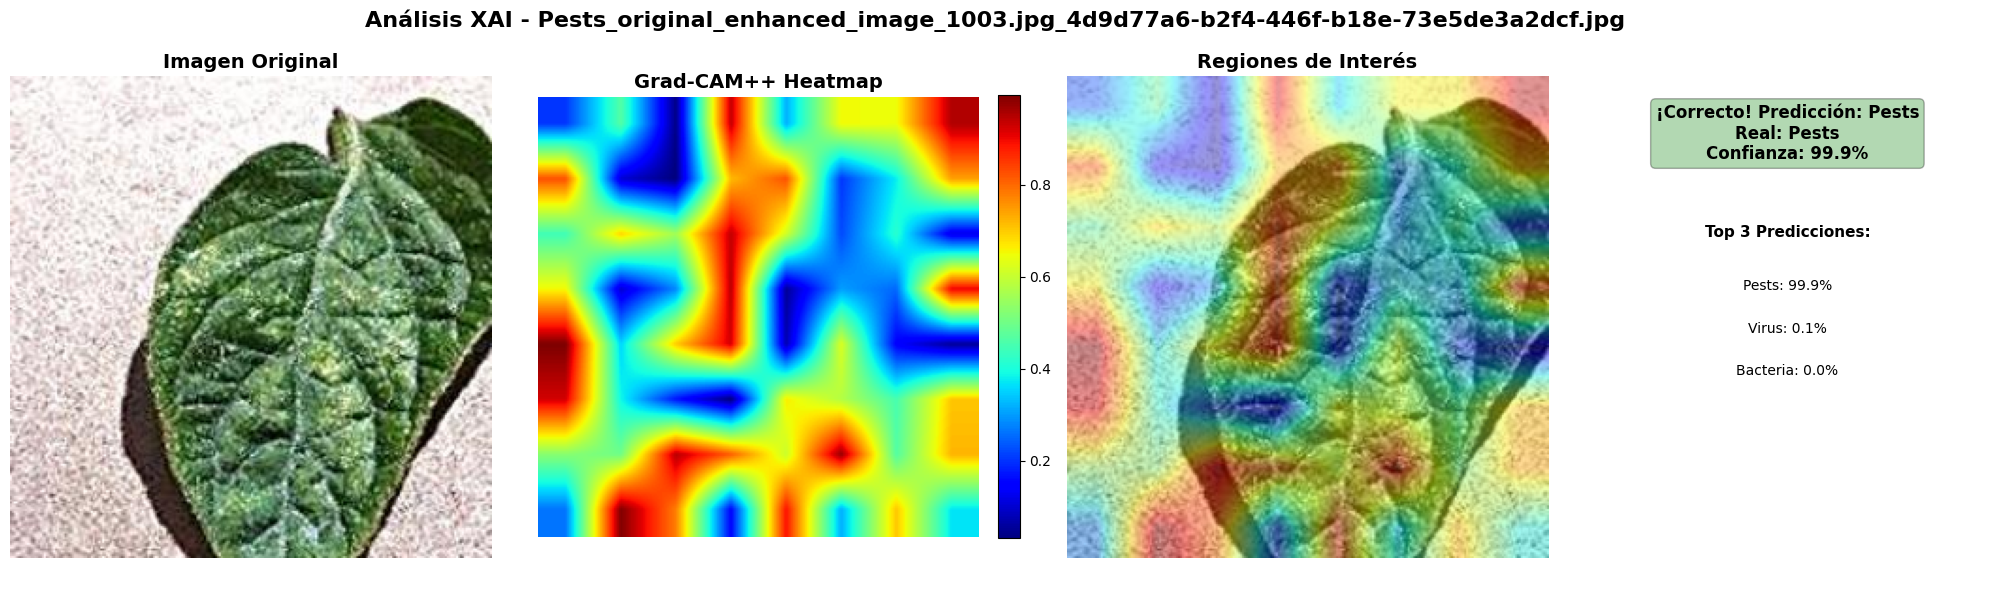


¡Proceso completado!


In [34]:
if __name__ == "__main__":

    print("\nPrueba de imagen específica...")
    test_single_image(
        image_path='/content/pathogen_data/pathogen/Pests/Pests_original_enhanced_image_1003.jpg_4d9d77a6-b2f4-446f-b18e-73e5de3a2dcf.jpg',
        true_label='Pests'
    )

    print("\n¡Proceso completado!")